# Quantum TSP

## Import libraries

In [1]:
# General References:
# [15] 
# [16] 
# [17] 
# [18] 

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, GroverOperator
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_algorithms import AmplificationProblem



## Graph 

In [2]:
#graph represent as weight from i to j

pi = np.pi

distances = [
    [0, pi / 2, pi / 4, pi / 8],
    [pi / 2, 0, pi / 4, pi / 4],
    [pi / 4, pi / 4, 0, pi / 8],
    [pi / 8, pi / 4, pi / 8, 0]
]

## Classical Approach

In [3]:
# References:
# [19]


# Number of cities
n=4

# Number of permutations of paths
ppaths = 2 ** n

# Make dynamic programming table:
dp = []

for i in range(0,ppaths):
    row = [math.inf] * n 
    dp.append(row)

# Initialize a table that stores the optimal path
pathTracker = []

for i in range(0,ppaths):
    row = [None] * n
    pathTracker.append(row)


# Set the starting weight to 0
dp[1][0] = 0

# Populate the backtracing table

# For each selection of cities
for mask in range(0,1 << n):

    # Go through each possible city that is not in the selection
    for previousCity in range(0,n):
        if not (mask & (1 << previousCity)):
            continue

        # Go through each city that is in the selection
        for nextCity in range(0,n):
            if mask & (1 << nextCity):
                continue

            # Create a new mask including the new city 
            newMask = mask | (1 << nextCity)
            # Calculate the new path cost
            newDist = dp[mask][previousCity] + distances[previousCity][nextCity]

            # Update table if it cheaper
            if newDist < dp[newMask][nextCity]:
                dp[newMask][nextCity] = newDist
                pathTracker[newMask][nextCity] = previousCity


# Get the min path weight and store the last visited city
minWeight = math.inf
finalCity = None

# BackTrack through the dp table
for previousCity in range(1, n):
    weight = dp[15][previousCity] + distances[previousCity][0]
    if weight < minWeight:
        minWeight = weight
        finalCity = previousCity

# Start at the last city and get the route taken
tour = []
mask = 15
lastCity = finalCity

# Until all cities are "unvisited"
while mask:
    # Add current city 
    tour.append(lastCity+1)
    # Get optimum previous city
    newLastCity = pathTracker[mask][lastCity]
    # Update mask by univisting city
    mask ^= (1 << lastCity)
    # Repeate with new city
    lastCity = newLastCity

# Reverse as we don't want back tracked path   
tour = tour[::-1]

# Out put
print("Tour:", tour)
print("Weight:", minWeight)

Tour: [1, 4, 2, 3]
Weight: 2.748893571891069


## Quantum Phase Finder

In [5]:
# References (theory):
# [2]
# [3] 

# Building the small unitary example

# Weights for each path cost 
a = 0
b = pi/10
c = 2*pi/10
d = 5*pi/10

# Create quantum circuit
qt = QuantumRegister(3, 'qt')
qct = QuantumCircuit(qt)

# Apply the unitaries

# CU(c-a) gate 
qct.cp(c - a, qt[0], qt[1])
# U(a) gate
qct.p(a, qt[0])
# CU(b-a) gate
qct.cp(b - a, qt[0], qt[2])

# CCU(d-c+a-b) applies using V V* V decomposition
qct.cp((d - c + a - b)/2, qt[1], qt[2])
qct.cx(qt[0], qt[1])
qct.cp(-(d - c + a - b)/2, qt[1], qt[2])
qct.cx(qt[0], qt[1])
qct.cp((d - c + a - b)/2, qt[0], qt[2])

# Output graph 
qct.draw()

┌──────┐                                                   
qt_0: ─■───────┤ P(0) ├─■────────────────────■───────────────■───■────────
       │P(π/5) └──────┘ │                  ┌─┴─┐           ┌─┴─┐ │        
qt_1: ─■────────────────┼─────────■────────┤ X ├─■─────────┤ X ├─┼────────
                        │P(π/10)  │P(π/10) └───┘ │P(-π/10) └───┘ │P(π/10) 
qt_2: ──────────────────■─────────■──────────────■───────────────■────────

In [7]:
# Full implementation
# Takes in path and returns path length as a phase

# Weights
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8]

# Possible cycles
cylces = ["11000110", "10001101", "10110100"]

# Creates CUj Unitary
def controlledUnitary(qc, qb: list, p: list): 
    # Assume p contain all the path lenghts phases

    # CU(c-a) 
    qc.cp(p[2]-p[0], qb[0], qb[1])
    # U(1)
    qc.p(p[0], qb[0])
    # CU(b-a)
    qc.cp(p[1]-p[0], qb[0], qb[2]) 
    
    # CC U1(d-c+a-b)
    qc.cp((p[3]-p[2]+p[0]-p[1])/2, qb[1], qb[2])
    qc.cx(qb[0], qb[1])
    qc.cp(-(p[3]-p[2]+p[0]-p[1])/2, qb[1], qb[2])
    qc.cx(qb[0], qb[1])
    qc.cp((p[3]-p[2]+p[0]-p[1])/2, qb[0], qb[2])

# Creates U by tensoring all Uj
def U(times, qc, unit, eigen, p: list): 
    # U1 = first 3 phases
    controlledUnitary(qc, [unit[0]]+eigen[0:2], [0]+p[0:3])
    # U2 = second 3 pahses
    controlledUnitary(qc, [unit[0]]+eigen[2:4], [p[3]]+[0]+p[4:6])
    # U3 = thrid 3 phases
    controlledUnitary(qc, [unit[0]]+eigen[4:6], p[6:8]+[0]+[p[8]])
    # U4 = last 3 pahses
    controlledUnitary(qc, [unit[0]]+eigen[6:8], p[9:12]+[0])

# Create CU, CU^2, CU^4, CU^8, CU^16, CU^32 to be applied to sets of qubits
def finalUs(base, eigen, p: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for i in range(0,2**base):
        U(base, qc, unit, eigen, p)
    return qc.to_gate(label='U'+'_'+(str(2**base)))

# Gets all possible path lenghths of multiple states (For Testing need to revert some arrays)
def allPathLengths(qc, eigen):

    # Hadarmard each qubit
    for i in range(0,len(eigen)):
        qc.h(eigen[i])  

    # flip gates to match input eigenstates
    for cycle in enumerate(cylces):
        for qbIndex, bit in enumerate(cycle):
            if bit == '0':
                qc.x(eigen[qbIndex])

        #revert back
        for qbIndex, bit in enumerate(cycle):
            if bit == '0':  
                qc.x(eigen[qbIndex])

# Creates superposition of eigen input for possible cycle
def customInput(qc, eigen, cycles):
    
    #make all amplitudes 0
    stateVector = [0] * (2**len(eigen))

    # Set wanted amplitudes 1 
    for cycle in cycles:
        stateVector[int(cycle, 2)] = 1

    # Normalise amplitudes
    normaliser = sum([amplitude**2 for amplitude in stateVector])**0.5
    stateVector = [amplitude / normaliser for amplitude in stateVector]

    # Circuit input
    qc.initialize(stateVector, eigen)

# Converts a single cylces into the quibit inputs by flipping 0's to 1
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if cylces[index][i] == '1':
            qc.x(eigen[i])
        if cylces[index][i] == '0':
            pass
    qc.barrier()
    return qc

# Creating circuit
# Defining bits
measuredbits = QuantumRegister(6, 'measu')
inputbit = QuantumRegister(8, 'input')
outputbit = ClassicalRegister(6, 'classic')
qc = QuantumCircuit(measuredbits, inputbit, outputbit)

# To get all path lengths
#allPathLengths(qc, inputbit)

# For all input path
customInput(qc, inputbit, cylces)

# For a single input path
#eigenstates(qc, inputbit, 2)


# Then hadamard the qubits we will measure
qc.h(measuredbits[:])
qc.barrier()

# Apply the CU gates
for i in range(0,6):
    qc.append(finalUs(i, inputbit, phases), [measuredbits[5-i]] + inputbit[:])

# Then apply the Inverse QFT (inverse is only to get the same unitary matrix over a equivalent rearranged version)
qft = QFT(num_qubits=len(measuredbits), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(measuredbits)])

# Measure the qubits
qc.measure(measuredbits, outputbit)

qc.draw()

»
  measu_0: »
           »
  measu_1: »
           »
  measu_2: »
           »
  measu_3: »
           »
  measu_4: »
           »
  measu_5: »
           »
  input_0: »
           »
  input_1: »
           »
  input_2: »
           »
  input_3: »
           »
  input_4: »
           »
  input_5: »
           »
  input_6: »
           »
  input_7: »
           »
classic: 6/»
           »
«                                                                                                                                                                                                                                                                                         ┌───┐                                                                                                                                                                                                                                                                               »
«  measu_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                                                                                                                                                                                                         ├───┤                                                                                                                                                                                                                                                                               »
«  measu_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                                                                                                                                                                                                         ├───┤                                                                                                                                                                                                                                                                               »
«  measu_2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                                                                                                                                                                       

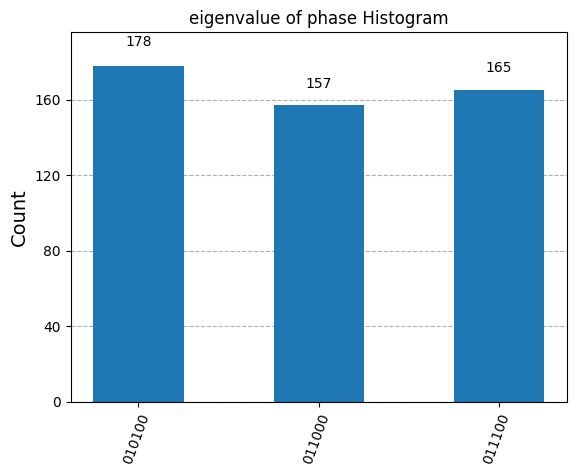

In [8]:
# Get eigen phase total weight


simulator_basic = BasicSimulator()

qc_t = transpile(qc, backend=simulator_basic)

job = simulator_basic.run(qc_t,shots=500)
result = job.result()

counts = result.get_counts()                    
plot_histogram(counts, title="eigenvalue of phase Histogram")


## Shortest Phase Finder

In [10]:
# References (Pseudocode + documentation code):
# [9]
# [3] (for grover's search)

# Eigenstate calcuclated from previous section
# (Can be created from scratch using AmplitudeAmplifier)

"""
qc = QuantumCircuit(6)

state_vector = np.zeros(2**n)
state_vector[35]= 1/np.sqrt(3)
state_vector[31]= 1/np.sqrt(3)
state_vector[27]= 1/np.sqrt(3)

qc.initialize(state_vector, [0,1,2,3,4,5])

qc.draw()

qc.measure_all()
"""

# Inputs and Outputs of phase finder
cycles = ["11000110", "10001101", "10000111"] 
cycleWeights = ["100100", "100000", "011100"] 

#Define Oracle
def oracle(D, d0, n):

    # Circuit of Oracle operator
    oracleCircuit = QuantumCircuit(n)
    
    # For each element in dictionary
    for val in D:
        # Check if it is less than picked state
        if val <= d0: 

            # Apply x gate to 0 bit 
            for i, bit in enumerate(val):
                if bit == '0':
                    oracleCircuit.x(i)
            
            # Mark state using CX gate
            oracleCircuit.mcx(list(range(n - 1)), n - 1)

            # Revert prior x gates
            for i, bit in enumerate(val):
                if bit == '0':
                    oracleCircuit.x(i)
    
    return oracleCircuit

# Define Diffusion operator
def amplitudeAmplifier(n):
    qc = QuantumCircuit(n)

    qc.h(range(0,n))
    qc.x(range(0,n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(0,n))
    qc.h(range(0,n))

    return qc

# Do grover Search to find mins
def groverSearch(D, d0, n):
    
    # Create circuit and initialse states
    qc = QuantumCircuit(n, n)
    qc.h(range(0,n))

    # Create the oracle and diffusion operator
    oracleCircuit = oracle(D, d0, n)
    amplifiedCircuit = amplitudeAmplifier(n)

    # do grover's required number of times
    iterations = int(pi/4*np.sqrt(len(D)))
    for i in range(0,iterations):
        qc.compose(oracleCircuit, inplace=True)
        qc.compose(amplifiedCircuit, inplace=True)

    # Measure result
    qc.measure(range(0,n), range(0,n))
    return qc


# Combine everyhting together
def getMin(D):

    # Get a random state
    d0 = D[0]  
    n = len(D[0])

    # Do some chosen number of times
    for i in range(0,len(D)):

        # Run grover search
        qc = groverSearch(D, d0, n)

        simulator_basic = BasicSimulator()

        qc_t = transpile(qc, backend=simulator_basic)
        job = simulator_basic.run(qc_t,shots=1000)
        result = job.result()
        counts = result.get_counts()
        
        # As qubit size is larger than iteration count (8 vs 6): ignore times when we get a non existant index
        valid = {
            k: v
            for k, v in counts.items()
                if int(k, 2) < len(D)
        }
        if not valid:
            continue

        # Get the most found state
        measuredState = max(valid, key=valid.get)
        index = int(measuredState, 2)

        d1 = D[index]

        if d1 < d0:
            d0 = d1

    return d0

minimum = getMin(cycleWeights)
print(f"The minimum is: {minimum}")


The minimum is: 011100


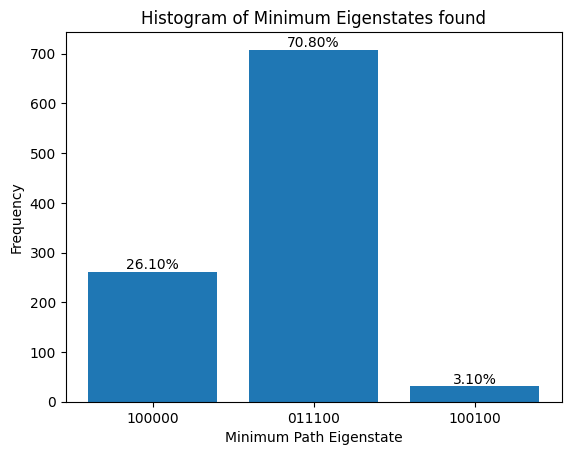

In [12]:
# Multiple trials
def multiRun(D, runs):
    results = []
    for i in range(0,runs):
        # Run the algorithm
        minimum = getMin(D)  
        # Store ollect the result
        results.append(minimum)  
    return results

# plot 
def displayResults(results):

    # Get Appearance count
    counts = {}
    for item in results:
        counts[item] = counts.get(item, 0) + 1  
    
    # Calculate percentages
    total = sum(counts.values())
    percentages = {key: (value / total) * 100 for key, value in counts.items()}

    # Plot  histogram
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Minimum Path Eigenstate")
    plt.ylabel("Frequency")
    plt.title("Histogram of Minimum Eigenstates found")

    # Display percentages on the graph
    for key, value in counts.items():
        percentage = percentages[key]
        plt.text(key, value, f"{percentage:.2f}%", ha='center', va='bottom')

    plt.show()

# Number of trials
runs = 1000 

results = multiRun(cycleWeights, runs)

# Plot the results
displayResults(results)



## References

[2] Karthik, Srinivasan, et al. “Efficient Quantum Algorithm for Solving Travelling Salesman Problem: An IBM Quantum Experience.” arXiv [Quant-Ph], 2018, http://arxiv.org/abs/1805.10928.]  
[3] Qiskit Community Textbook. https://github.com/qiskit-community/qiskit-textbook.   
[9] Chen, Yanhu, et al. “An Optimized Quantum Maximum or Minimum Searching Algorithm and Its Circuits.” arXiv [Quant-Ph], 2019, doi:10.48550/ARXIV.1908.07943.  
[15] Qiskit. Coding with Qiskit - 1.X. Youtube, http://www.youtube.com/playlist?list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi.
[16] Serrano, Diego Emilio. Using Qiskit v1.x | Part 3 - Qiskit’s BasicSimulator. Youtube, 2024, https://www.youtube.com/watch?v=EF7PQ_F4e8I.  
[17] “Qiskit SDK API Documentation (Latest Version).” IBM Quantum Documentation, https://docs.quantum.ibm.com/api/qiskit.  
[18] Qiskit Textbook. https://github.com/Qiskit/textbook.
[19] Liang, David. “Intro — Python Algorithms: Traveling Salesman Problem.” Medium, 17 July 2024, https://medium.com/@davidlfliang/intro-python-algorithms-traveling-salesman-problem-ffa61f0bd47b.  
